# Elemental Carbon Database 
Required system packages and initialization

In [1]:
import pandas as pd
import numpy as np
import sympy as sym
import os
import thermoengine
import dill

from scipy import optimize

sym.init_printing()

import matplotlib.pyplot  as plt

# Load available coder modules & phases

In [2]:
%run core.ipynb

In [3]:
load_coder_modules()

In [4]:
with open('carbon-phases.pkl','rb') as file:
    output = dill.load(file)
    file.close()
    
output

{'Arg': <thermoengine.phases.PurePhase at 0x1227ab198>,
 'Cal': <thermoengine.phases.PurePhase at 0x122782278>,
 'Dol': <thermoengine.phases.PurePhase at 0x122792550>,
 'Mgs': <thermoengine.phases.PurePhase at 0x1227a1400>,
 'Sd': <thermoengine.phases.PurePhase at 0x1220ea2e8>}

# Fitting a reasonable high-temp Cp model
* Saxena data from NIST provides carbon properties accurately from 250K to 1200K
* high temperature extrapolation of diamond is an UNPHYSICAL MESS
* not appropriate for the mantle


In [5]:
def saxena_cp(k, T):
    return k[0] + k[1]*T + k[2]/T**2 + k[3]*T**2 + k[4]/T**3 + k[5]/np.sqrt(T) + k[6]/T

def berman_cp(k, T):
    return k[0]+k[1]/np.sqrt(T)+ k[2]/T**2 + k[3]/T**3

k_cp_saxena_Dia = [98.45, -3.655e-2, 1.217e6, 1.098e-5, 0.0, -1.659e3, 0.0]
k_cp_saxena_Gr = [60.86, -1.024e-2, 7.139e5, 1.669e-6, 0.0, -9.922e2, 0.0]

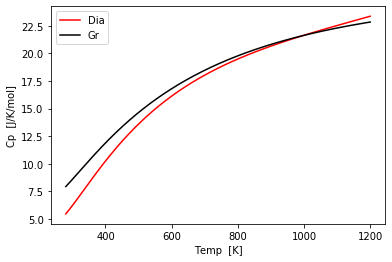

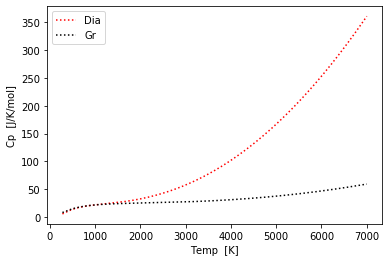

In [6]:


T= np.linspace(280, 1200.0,2001)
T_full= np.linspace(280, 7000.0,2001)
# Cp_Dia = saxena_cp(k_cp_saxena_Dia, T)
# Cp_Gr = saxena_cp(k_cp_saxena_Gr, T)

plt.figure()
plt.plot(T, saxena_cp(k_cp_saxena_Dia,T), 'r-',label='Dia')
plt.plot(T, saxena_cp(k_cp_saxena_Gr,T), 'k-', label='Gr')
plt.xlabel('Temp  [K]')
plt.ylabel('Cp  [J/K/mol]')
plt.legend()

plt.figure()
plt.plot(T_full, saxena_cp(k_cp_saxena_Dia,T_full), 'r:',label='Dia')
plt.plot(T_full, saxena_cp(k_cp_saxena_Gr,T_full), 'k:',label='Gr')
plt.xlabel('Temp  [K]')
plt.ylabel('Cp  [J/K/mol]')
plt.legend()
# plt.ylabel('% Deviation')

# Fit this to safe Berman Cp form using least squares
* data is robust from 280K to 1200K, so we will fit that
* create fitting or (design) matrix for Berman model representing each temp-dependent term

In [7]:
T= np.linspace(280, 1200.0,2001)
Cp_Dia = saxena_cp(k_cp_saxena_Dia, T)
Cp_Gr = saxena_cp(k_cp_saxena_Gr, T)


Tmat = np.vstack((np.ones(T.size), 
                  1/np.sqrt(T), 
                  1/T**2, 
                  1/T**3)).T

k_Cp_Dia = np.linalg.lstsq(Tmat, Cp_Dia, rcond=None)[0]
k_Cp_Gr = np.linalg.lstsq(Tmat, Cp_Gr, rcond=None)[0]

print('Diamond = ', k_Cp_Dia)

print('Graphite = ', k_Cp_Gr)

Diamond =  [ 3.69192828e+01 -4.45392029e+02 -1.45260923e+06  3.00595719e+08]
Graphite =  [ 3.41489767e+01 -3.60679017e+02 -1.44488502e+06  3.05863998e+08]


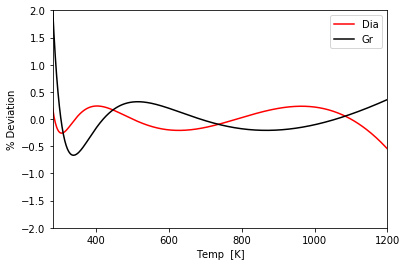

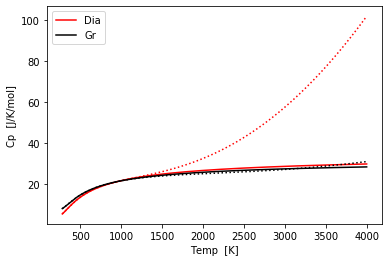

In [8]:

T= np.linspace(280, 4000.0,2001)

Cp_Dia = saxena_cp(k_cp_saxena_Dia, T)
Cp_Gr = saxena_cp(k_cp_saxena_Gr, T)

plt.figure()
plt.plot(T, 100*(berman_cp(k_Cp_Dia,T)/Cp_Dia-1), 'r-',label='Dia')
plt.plot(T, 100*(berman_cp(k_Cp_Gr,T)/Cp_Gr-1), 'k-',label='Gr')
plt.xlim(280,1200)
plt.ylim(-2,2)
plt.xlabel('Temp  [K]')
plt.ylabel('% Deviation')
plt.legend()



plt.figure()
plt.plot(T, berman_cp(k_Cp_Dia,T), 'r-',label='Dia')
plt.plot(T, saxena_cp(k_cp_saxena_Dia, T), 'r:')
plt.plot(T, berman_cp(k_Cp_Gr,T), 'k-',label='Gr')
plt.plot(T, saxena_cp(k_cp_saxena_Gr, T), 'k:')
plt.xlabel('Temp  [K]')
plt.ylabel('Cp  [J/K/mol]')
plt.legend()


# Create Frankenstein coder module for elemental Carbon
* Head over to coder Notebooks to see how Cp model and EOS are defined

In [9]:
# %run HP11-std-state.ipynb
# %run modHP11-std-state.ipynb

In [10]:
# %run mod-Berman-std-state.ipynb

%run init-coder-model.ipynb
%run Berman-Cp-model.ipynb 
%run thermal-Murnaghan-EOS.ipynb

In [11]:
def mod_Berman_params(Phase='Name', Formula='', 
                      H_TrPr=-1e6, S_TrPr=1e2, V_TrPr=3,
                      k0=1e2, k1=-10.0E2, k2=-5.0E5, k3=16.667E7,
                      alpha0=1.0E-5, K0=100.0, K_P=4.0):
    
    param_dict = {
        'Phase': Phase, 'Formula': Formula,
        'T_r': 298.15, 'P_r': 1.0,
        'H_TrPr': H_TrPr, 'S_TrPr': S_TrPr, 'V_TrPr': V_TrPr,
        'k0': k0, 'k1': k1, 'k2': k2, 'k3': k3,
        'alpha0':alpha0, 'K0':K0, 'K_P':K_P}
    return param_dict

# Store parameters for elemental Carbon (Graphite & Diamond)
* heat capacities from reparameterized Saxena data (represented using Berman form)
* Std State properties from NIST
* EOS from Saxena, reparameterized to thermal-murnaghan EOS

In [12]:
phase_params = {}

In [13]:
lookup_phase_info('diamond')

Abbrev     Name Formula Parent
54    Dia  Diamond       C    NaN

In [14]:

phase_params['Dia'] = mod_Berman_params(
    Phase='Diamond', Formula='C(1)',
    H_TrPr=1900.0, S_TrPr=2.38, V_TrPr=0.3417,
    k0=k_Cp_Dia[0], k1=k_Cp_Dia[1], k2=k_Cp_Dia[2], k3=k_Cp_Dia[3],
    alpha0=0.2243e-4, K0=444.0*1e4, K_P=1.9)



In [15]:
lookup_phase_info('graphite')

Abbrev      Name Formula Parent
87     Gr  Graphite       C    NaN

In [16]:

phase_params['Gr'] = mod_Berman_params(
    Phase='Graphite', Formula='C(1)',
    H_TrPr=0.0, S_TrPr=5.74, V_TrPr=0.5298,
    k0=k_Cp_Gr[0], k1=k_Cp_Gr[1], k2=k_Cp_Gr[2], k3=k_Cp_Gr[3],
    alpha0=0.3460e-4, K0=33.8*1e4, K_P=8.9)



In [17]:
modelDB, coder_mod = make_custom_database('saxena', phase_params)

/Users/aswolf/Documents/projects/ENKI/ThermoEngine/Notebooks/Carbonated-Mantle/working
Creating (once only) generic fast model code file string
Creating (once only) generic model calib code template include file string
Creating (once only) generic model calib code template code file string
Creating (once only) generic calib model code file string
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  saxena
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  saxena
/Us

In [18]:
display(modelDB.phase_info)
Dia = modelDB.get_phase('Dia')
Gr = modelDB.get_phase('Gr')

abbrev phase_name formula phase_type endmember_num
0    Liq     Liquid           solution            15
1    Dia    Diamond       C       pure             1
2     Gr   Graphite       C       pure             1
3    H2O      Water     H2O       pure             1

# Create Reaction and test phase boundary
* Gr -> Dia

In [19]:
rxn = modelDB.get_rxn(['Gr','Dia'], [0,0], [-1, +1])

* Verify that Graphite is stable at Std temp and press
* affinity should be negative (toward graphite)

In [20]:
rxn.affinity(298.15, 1)

array([-2901.59590075])

# Manually determine rxn boundary for messy problems

In [21]:
P = np.linspace(1, 50e4,101)
Tlims = [100, 5000]

Tbnd = np.tile(np.nan, P.shape)

for ind, iP in enumerate(P):
    fun = lambda T, P=iP: rxn.affinity(T, P)
    try:
        Tbnd[ind]=optimize.brentq(fun, Tlims[0], Tlims[1])
    except:
        continue

Text(3000, 4, 'Graphite')

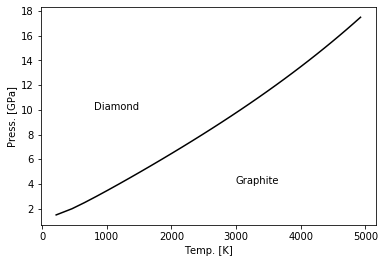

In [22]:
plt.figure()
plt.plot(Tbnd, P/1e4, 'k-')

plt.ylabel('Press. [GPa]')
plt.xlabel('Temp. [K]')

plt.text(800,10, 'Diamond')
plt.text(3000,4, 'Graphite')

Text(3000, 4, 'Graphite')

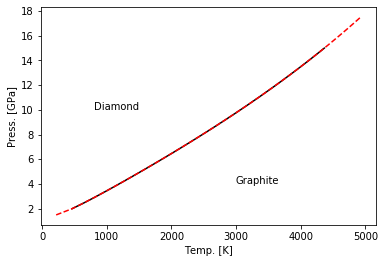

In [23]:
T_bnd, P_bnd = rxn.trace_boundary(Plims=[2e4,15e4])
plt.figure()
plt.plot(T_bnd, P_bnd/1e4,'k-')

plt.plot(Tbnd, P/1e4, 'r--')


plt.ylabel('Press. [GPa]')
plt.xlabel('Temp. [K]')

plt.text(800, 10,'Diamond')
plt.text(3000, 4,'Graphite')

# Store resulting phases

In [24]:

for phsnm in phase_params:
    iphs = modelDB.get_phase(phsnm)
    output[phsnm] = iphs
    
output

{'Arg': <thermoengine.phases.PurePhase at 0x1227ab198>,
 'Cal': <thermoengine.phases.PurePhase at 0x122782278>,
 'Dia': <thermoengine.phases.PurePhase at 0x1229efb00>,
 'Dol': <thermoengine.phases.PurePhase at 0x122792550>,
 'Gr': <thermoengine.phases.PurePhase at 0x1229efa90>,
 'Mgs': <thermoengine.phases.PurePhase at 0x1227a1400>,
 'Sd': <thermoengine.phases.PurePhase at 0x1220ea2e8>}

In [25]:
with open('carbon-phases.pkl','wb') as file:
    dill.dump(output, file)
    file.close()

# ...Extra Code for fooling around

In [26]:
def HP11_params(Phase='Name', Formula='', 
                H_TrPr=-1e6, S_TrPr=1e2, V_TrPr=3,
                a_cp=100, b_cp=-1.0e-2, c_cp=3.0e6, d_cp=1.0e-6,
                alpha0=1.0E-5, K0=100.0, K_P=4.0, n=1):
    
    param_dict = {
        'Phase': Phase, 'Formula': Formula,
        'T_r': 298.15, 'P_r': 1.0,
        'H_TrPr': H_TrPr, 'S_TrPr': S_TrPr, 'V_TrPr': V_TrPr,
        'a_cp': a_cp, 'b_cp': b_cp, 'c_cp': c_cp, 'd_cp': d_cp, 
        'alpha0':alpha0, 'K0':K0, 'K_P':K_P, 'n':n}
    return param_dict

In [27]:
def modHP11_params(Phase='Name', Formula='', 
                   H_TrPr=-1e6, S_TrPr=1e2, V_TrPr=3,
                   a_cp=100, b_cp=-1.0e-2, c_cp=3.0e6, d_cp=1.0e-6,
                   alpha0=1.0E-5, K0=100.0, K_P=4.0):
    
    param_dict = {
        'Phase': Phase, 'Formula': Formula,
        'T_r': 298.15, 'P_r': 1.0,
        'H_TrPr': H_TrPr, 'S_TrPr': S_TrPr, 'V_TrPr': V_TrPr,
        'a_cp': a_cp, 'b_cp': b_cp, 'c_cp': c_cp, 'd_cp': d_cp, 
        'alpha0':alpha0, 'K0':K0, 'K_P':K_P}
    return param_dict

In [28]:
def Saxena_params(Phase='Name', Formula='', 
                  H_TrPr=-1e6, S_TrPr=1e2, V_TrPr=3,
                  a_cp=100, b_cp=-1.0e-2, c_cp=3.0e6, d_cp=1.0e-6,
                  e_cp=0.0, g_cp=-1.0e3, h_cp=0.0,
                  alpha0=1.0E-5, K0=100.0, K_P=4.0):
    
    param_dict = {
        'Phase': Phase, 'Formula': Formula,
        'T_r': 298.15, 'P_r': 1.0,
        'H_TrPr': H_TrPr, 'S_TrPr': S_TrPr, 'V_TrPr': V_TrPr,
        'a_cp': a_cp, 'b_cp': b_cp, 'c_cp': c_cp, 'd_cp': d_cp, 
        'e_cp':e_cp, 'g_cp':g_cp, 'h_cp':h_cp,
        'alpha0':alpha0, 'K0':K0, 'K_P':K_P}
    return param_dict

In [29]:

# phase_params['Dia'] = Saxena_params(
#     Phase='Diamond', Formula='C(1)',
#     H_TrPr=2000.0, S_TrPr=2.38, V_TrPr=0.342,
#     a_cp=.0243, b_cp=.6272, c_cp=-377.4, d_cp=-.2734,
#     alpha0=0.2243e-4, K0=444.0*1e4, K_P=1.9)

# phase_params['Dia'] = Saxena_params(
#     Phase='Diamond', Formula='C(1)',
#     H_TrPr=1900.0, S_TrPr=2.38, V_TrPr=0.3417,
#     a_cp=98.45, b_cp=-3.655e-2, c_cp=1.217e6, d_cp=1.098e-5,
#     e_cp=0.0, g_cp=-1.659e3, h_cp=0.0,
#     alpha0=0.2243e-4, K0=444.0*1e4, K_P=1.9)


# phase_params['Gr'] = modHP11_params(
#     Phase='Graphite', Formula='C(1)',
#     H_TrPr=0.0, S_TrPr=5.74, V_TrPr=0.53,
#     a_cp=0.051, b_cp=-.4429, c_cp=488.6, d_cp=-.8055,
#     alpha0=0.3460e-4, K0=33.8*1e4, K_P=8.9)

# phase_params['Gr'] = Saxena_params(
#     Phase='Graphite', Formula='C(1)',
#     H_TrPr=0.0, S_TrPr=5.74, V_TrPr=0.5298,
#     a_cp=60.86, b_cp=-1.024e-2, c_cp=7.139e5, d_cp=1.669e-6,
#     e_cp=0.0, g_cp=-9.922e2, h_cp=0.0,
#     alpha0=0.3460e-4, K0=33.8*1e4, K_P=8.9)
# V_TrPr=0.5298